In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates

import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib.colors import LogNorm

from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch


from astropy.io import fits




In [2]:
# Assembly task
# https://github.com/lsst/ip_isr/blob/main/python/lsst/ip/isr/isrTask.py

from lsst.ip.isr.assembleCcdTask import (AssembleCcdConfig, AssembleCcdTask)
from lsst.ip.isr.isrTask import (IsrTask, IsrTaskConfig)

#https://github.com/lsst/ip_isr/blob/main/python/lsst/ip/isr/overscan.py
from lsst.ip.isr import  OverscanCorrectionTaskConfig, OverscanCorrectionTask

In [3]:
# LSST Display
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
! eups list -s

afw                   g4728e35f0d+53a8438ab4 	current w_2023_38 setup
alert_packet          g6041bd2d66 	current w_2023_38 setup
analysis_drp          g8a53795882+8240499edc 	current w_2023_38 setup
analysis_tools        g1887775915+c89e410209 	current w_2023_38 setup
ap_association        g6a6fcd37b7+f81e0a4cd9 	current w_2023_38 setup
ap_pipe               g06c608b3b8+0cce5f0898 	current w_2023_38 setup
ap_verify             gf37a9491f6+9462b9949d 	current w_2023_38 setup
astro_metadata_translator g0978aabd1f+0ce179faa8 	current w_2023_38 setup
astshim               g3273194fdb+f6908454ef 	current w_2023_38 setup
atmospec              LOCAL:/home/m/monroy/repos/repos_w_2023_35/atmospec 	setup
base                  g98ffbb4407+81bc2a20b4 	current w_2023_38 setup
cbp                   ga32fcf49c8+387721ca5c 	current w_2023_38 setup
cell_coadds           g9faf7ed3f3+8240499edc 	current w_2023_38 setup
coadd_utils           g337abbeb29+387721ca5c 	current w_2023_38 setup
cp_pipe         

# Butler 

In [6]:
import lsst.daf.butler as dafButler

In [7]:
embargo = True

In [8]:
if embargo:
    repo="/sdf/group/rubin/repo/oga/"
else:
    repo = "/sdf/group/rubin/repo/main"
butler = dafButler.Butler(repo)
registry = butler.registry

In [9]:
cameraName = 'LATISS'
calibCollections = ['LATISS/defaults','LATISS/raw/all']
for col in registry.queryCollections("*LATISS/calib*"):
    #print(col)
    calibCollections.append(col)

# Paths 

In [10]:
outdir_base = 'output_fits/'
if os.path.exists(outdir_base)==False:
    os.mkdir(outdir_base)
outdir_label = 'sky_hologram_flat_{0}/'

We check the different dimension records existing for *physical_filter*: 

In [11]:
phys_filters = list(registry.queryDimensionRecords('physical_filter',where="instrument='LATISS'"))

Print physical_filters with hologram in place: 

In [12]:
for f_ in phys_filters:
    if 'holo' in f_.name:
        print(f_.name)

empty~holo4_003
blank_bk7_wg05~holo4_003
KPNO_1111_436nm~holo4_003
KPNO_373A_677nm~holo4_003
KPNO_406_828nm~holo4_003
unknown~holo4_003
BG40~holo4_003
quadnotch1~holo4_003
RG610~holo4_003
FELH0600~holo4_003
SDSSg~holo4_003
SDSSr~holo4_003
SDSSi~holo4_003
BG40_65mm_1~holo4_003
BG40_65mm_2~holo4_003
OG550_65mm_1~holo4_003
OG550_65mm_2~holo4_003
SDSSg_65mm~holo4_003
SDSSr_65mm~holo4_003
SDSSi_65mm~holo4_003
SDSSu_65mm~holo4_003
SDSSz_65mm~holo4_003
SDSSy_65mm~holo4_003
empty~holo4_001
blank_bk7_wg05~holo4_001
KPNO_1111_436nm~holo4_001
KPNO_373A_677nm~holo4_001
KPNO_406_828nm~holo4_001
unknown~holo4_001
BG40~holo4_001
BG40_65mm_1~holo4_001
BG40_65mm_2~holo4_001
quadnotch1~holo4_001
RG610~holo4_001
OG550_65mm_1~holo4_001
OG550_65mm_2~holo4_001
FELH0600~holo4_001
SDSSg~holo4_001
SDSSr~holo4_001
SDSSi~holo4_001
SDSSu_65mm~holo4_001
SDSSg_65mm~holo4_001
SDSSr_65mm~holo4_001
SDSSi_65mm~holo4_001
SDSSz_65mm~holo4_001
SDSSy_65mm~holo4_001
collimator~holo4_003
collimator~holo4_001
cyl_lens~holo4_0

In [24]:
obs_type = 'engtest'
obs_day = 20230921
target = 'slew_icrs' #Note that there are no exposure with this config for the moment 

In [25]:
df_science = pd.DataFrame(columns=['id', 'obs_id','day_obs', 'seq_num','time_start',
                                    'time_end' ,'type', 'target','filter_disp','zenith_angle',
                                    'exp_time','ra','dec','skyangle','science_program'])

In [26]:

where_exps = "instrument='LATISS' AND exposure.observation_type='{0}' AND exposure.day_obs={1} AND exposure.target_name='{2}'".format(obs_type,obs_day,target)
#where_exps = "instrument='LATISS' AND exposure.observation_type='{0}' AND exposure.day_obs={1}".format(obs_type,obs_day)
for i, info in enumerate(registry.queryDimensionRecords('exposure',where=where_exps)):
    
    #if info.observation_type=='science':
    id_ = info.id
    obs_id_ = info.obs_id
    day_obs_ = info.day_obs
    seq_num_ = info.seq_num
    timespan_ = info.timespan
    timespan_begin_ = pd.to_datetime(timespan_.begin.to_string())
    timespan_end_ = pd.to_datetime(timespan_.end.to_string())
    timespan_begin_jd_ = timespan_.begin.jd
    timespan_begin_mjd_ = timespan_.begin.mjd

    observation_type_ = info.observation_type
    target_name_ = info.target_name
    physical_filter_ = info.physical_filter
    zenith_angle_ = info.zenith_angle
    exposure_time_ = info.exposure_time
    tracking_ra_ = info.tracking_ra
    tracking_dec_ = info.tracking_dec
    sky_angle_ = info.sky_angle
    science_program_ = info.science_program

    df_science.loc[i] = [id_, obs_id_, day_obs_, seq_num_,timespan_begin_,timespan_end_ ,observation_type_, \
                         target_name_, physical_filter_, zenith_angle_, exposure_time_,tracking_ra_, \
                         tracking_dec_, sky_angle_, science_program_]

    if i < 2:
        print(i)
        print(info)
        print("\t timespan:            ",info.timespan)
        print("\t timespan.begin:      ",info.timespan.begin)
        print("\t id:                  ",info.id)
        print("\t day_obs:             ",info.day_obs)
        print("\t seq_num:             ",info.seq_num)
        print("\t type-of-observation: ",info.observation_type)
        print("\t target:              ",info.target_name)
        print("-----------------------------------------------------")
    

0
exposure:
  instrument: 'LATISS'
  id: 2023092100319
  physical_filter: 'SDSSg_65mm~pinhole_1_1000'
  obs_id: 'AT_O_20230921_000319'
  exposure_time: 30.0
  dark_time: 30.2282
  observation_type: 'engtest'
  observation_reason: 'engtest'
  day_obs: 20230921
  seq_num: 319
  seq_start: 319
  seq_end: 319
  group_name: '2023-09-21T22:47:34.136'
  group_id: 2752660541360000
  target_name: 'slew_icrs'
  science_program: 'unknown'
  tracking_ra: 282.5075523925613
  tracking_dec: -29.764322742184238
  sky_angle: 184.21772338204977
  azimuth: 89.90480604252305
  zenith_angle: 9.836382143305684
  has_simulated: False
  timespan: Timespan(begin=astropy.time.Time('2023-09-21 22:47:34.572996', scale='tai', format='iso'), end=astropy.time.Time('2023-09-21 22:48:04.802000', scale='tai', format='iso'))
	 timespan:             [2023-09-21T22:47:34.572996, 2023-09-21T22:48:04.802000)
	 timespan.begin:       2023-09-21 22:47:34.572996
	 id:                   2023092100319
	 day_obs:              2023

In [27]:
print('Number of entries = ',len(df_science))

Number of entries =  63


In [31]:
df_science

,id,obs_id,day_obs,seq_num,time_start,time_end,type,target,filter_disp,zenith_angle,exp_time,ra,dec,skyangle,science_program
0,2023092100319,AT_O_20230921_000319,20230921,319,2023-09-21 22:47:34.572996,2023-09-21 22:48:04.802,engtest,slew_icrs,SDSSg_65mm~pinhole_1_1000,9.836382,30.0,282.507552,-29.764323,184.217723,unknown
1,2023092100322,AT_O_20230921_000322,20230921,322,2023-09-21 22:51:13.178007,2023-09-21 22:51:43.413,engtest,slew_icrs,empty~pinhole_1_1000,9.075017,30.0,282.533947,-29.739322,184.222980,unknown
2,2023092100325,AT_O_20230921_000325,20230921,325,2023-09-21 22:53:16.094982,2023-09-21 22:53:46.329,engtest,slew_icrs,SDSSg_65mm~pinhole_1_1000,8.604128,30.0,282.503122,-29.743820,184.217923,unknown
3,2023092100328,AT_O_20230921_000328,20230921,328,2023-09-21 22:55:20.773003,2023-09-21 22:55:51.013,engtest,slew_icrs,SDSSr_65mm~pinhole_1_1000,8.186600,30.0,282.540157,-29.729598,184.217532,unknown
4,2023092100331,AT_O_20230921_000331,20230921,331,2023-09-21 23:00:51.291990,2023-09-21 23:01:01.527,engtest,slew_icrs,empty~empty,7.020640,10.0,282.571489,-29.755838,184.219036,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,2023092100400,AT_O_20230921_000400,20230921,400,2023-09-22 00:40:50.301012,2023-09-22 00:41:05.543,engtest,slew_icrs,empty~pinhole_1_1000,37.978760,15.0,256.215965,-26.859454,40.775400,unknown
59,2023092100403,AT_O_20230921_000403,20230921,403,2023-09-22 00:49:09.591002,2023-09-22 00:49:09.917,engtest,slew_icrs,empty~empty,39.695760,0.1,256.287055,-26.913796,40.775743,unknown
60,2023092100409,AT_O_20230921_000409,20230921,409,2023-09-22 00:51:47.437983,2023-09-22 00:51:47.769,engtest,slew_icrs,SDSSr_65mm~empty,40.261666,0.1,256.286875,-26.914297,40.775169,unknown
61,2023092100490,AT_O_20230921_000490,20230921,490,2023-09-22 03:36:20.911003,2023-09-22 03:36:22.154,engtest,slew_icrs,SDSSr_65mm~empty,66.019750,1.0,70.003346,-46.884575,226.680211,unknown


Select exposures: 

In [29]:
seq_nums = np.sort(np.array(df_science.seq_num))
print(seq_nums)

[319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336
 337 338 339 340 341 342 343 344 345 346 347 348 374 375 376 377 378 379
 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397
 398 399 400 401 402 403 409 490 511]


In [32]:
ids = np.sort(np.array(df_science.id))
print(ids)

[2023092100319 2023092100320 2023092100321 2023092100322 2023092100323
 2023092100324 2023092100325 2023092100326 2023092100327 2023092100328
 2023092100329 2023092100330 2023092100331 2023092100332 2023092100333
 2023092100334 2023092100335 2023092100336 2023092100337 2023092100338
 2023092100339 2023092100340 2023092100341 2023092100342 2023092100343
 2023092100344 2023092100345 2023092100346 2023092100347 2023092100348
 2023092100374 2023092100375 2023092100376 2023092100377 2023092100378
 2023092100379 2023092100380 2023092100381 2023092100382 2023092100383
 2023092100384 2023092100385 2023092100386 2023092100387 2023092100388
 2023092100389 2023092100390 2023092100391 2023092100392 2023092100393
 2023092100394 2023092100395 2023092100396 2023092100397 2023092100398
 2023092100399 2023092100400 2023092100401 2023092100402 2023092100403
 2023092100409 2023092100490 2023092100511]


We test retrieving one of them: 

In [33]:
seq_num0 = seq_nums[0]
exp_id0 = ids[0]
print(exp_id0)

2023092100319


In [34]:
test_img = butler.get('raw', dataId={'exposure': exp_id0, 'instrument': 'LATISS', 'detector': 0}, collections = calibCollections)

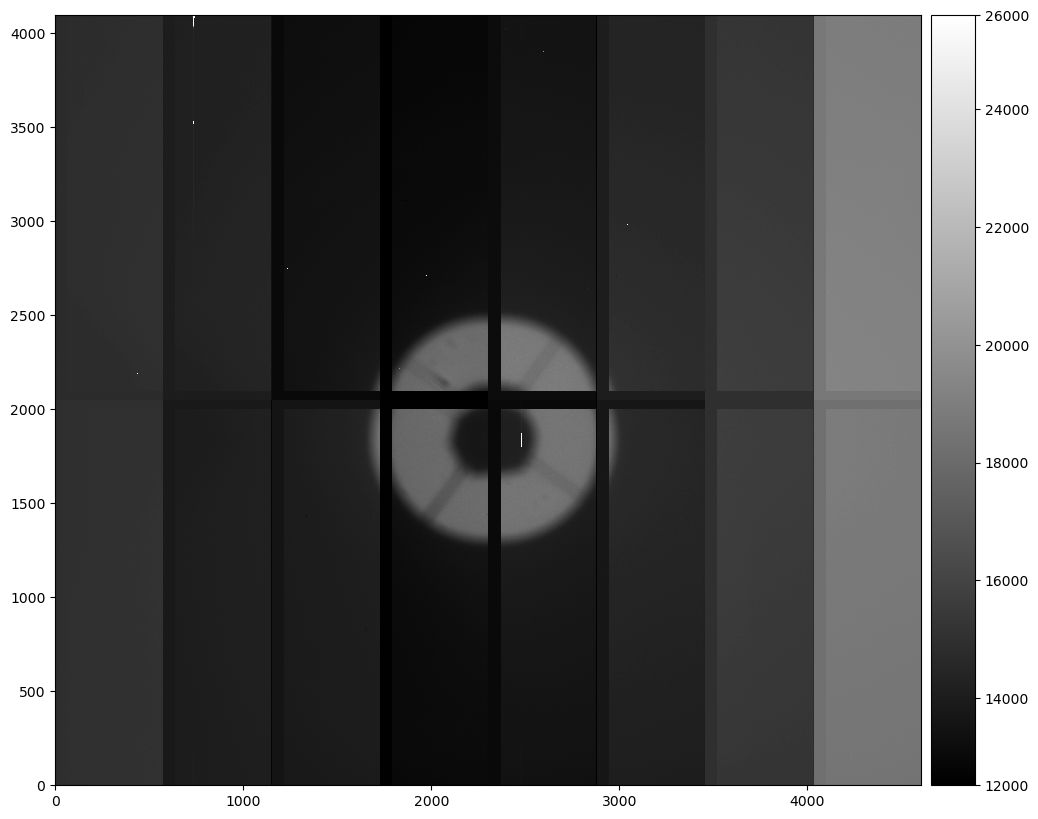

In [35]:
fig = plt.figure(figsize=(12,10))
afw_display = afwDisplay.Display(frame=fig)
afw_display.scale('linear', 'zscale',None)
afw_display.mtv(test_img.image)

## Organize amplifiers 

In [36]:
ampli_boxes = {}
ampli_names = []
for ampIdx, amp in enumerate(test_img.getDetector()):
    ampli_name_ = amp.getName()
    ampli_names.append(ampli_name_)
    xbegin = amp.getBBox().x.begin
    xend = amp.getBBox().x.end
    ybegin = amp.getBBox().y.begin
    yend = amp.getBBox().y.end
    ampli_boxes[ampli_name_] = (xbegin,xend,ybegin,yend)

In [37]:
ampli_boxes

{'C10': (0, 509, 2000, 4000),
 'C11': (509, 1018, 2000, 4000),
 'C12': (1018, 1527, 2000, 4000),
 'C13': (1527, 2036, 2000, 4000),
 'C14': (2036, 2545, 2000, 4000),
 'C15': (2545, 3054, 2000, 4000),
 'C16': (3054, 3563, 2000, 4000),
 'C17': (3563, 4072, 2000, 4000),
 'C07': (3563, 4072, 0, 2000),
 'C06': (3054, 3563, 0, 2000),
 'C05': (2545, 3054, 0, 2000),
 'C04': (2036, 2545, 0, 2000),
 'C03': (1527, 2036, 0, 2000),
 'C02': (1018, 1527, 0, 2000),
 'C01': (509, 1018, 0, 2000),
 'C00': (0, 509, 0, 2000)}

We do the ISR on this image the same way we do it with the spectra images (i.e., we do our pseudo-postISRCCD): 

In [38]:
# configuration
isr_config =  IsrTaskConfig()

In [39]:
isr_config.doDark = False
isr_config.doFlat =  False
isr_config.doFringe = False
isr_config.doDefect = True
isr_config.doLinearize = False
isr_config.doCrosstalk =  False
isr_config.doSaturationInterpolation = False
isr_config.overscan.fitType: 'MEDIAN_PER_ROW'
isr_config.doBias: True


In [40]:
isr_task = IsrTask(config=isr_config)

In [41]:
butler = dafButler.Butler(repo, collections=calibCollections)
camera = butler.get('camera', instrument=cameraName)
#bias = butler.get('bias',instrument=cameraName,detector=0)
#defects = butler.get('defects',instrument=cameraName,detector=0)

In [42]:

bias = butler.get("bias",instrument=cameraName, exposure= exp_id0, detector=0, collections=calibCollections)
defects = butler.get('defects',instrument=cameraName, exposure= exp_id0,detector=0,collections=calibCollections)

#fast ISR 
isr_test = isr_task.run(test_img,bias=bias,defects=defects)


In [43]:
test_ = isr_test.exposure.image.array

Value range 

In [44]:
np.min(test_.flatten())

-18.295828

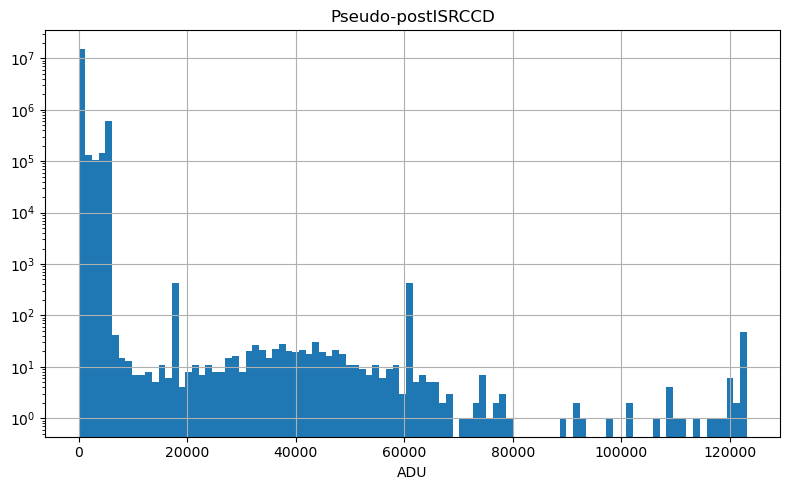

In [45]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
_ = ax.hist(test_.flatten(),bins=100)
ax.set_yscale("log")
ax.grid()
ax.set_xlabel('ADU')
ax.set_title('Pseudo-postISRCCD')
plt.tight_layout()

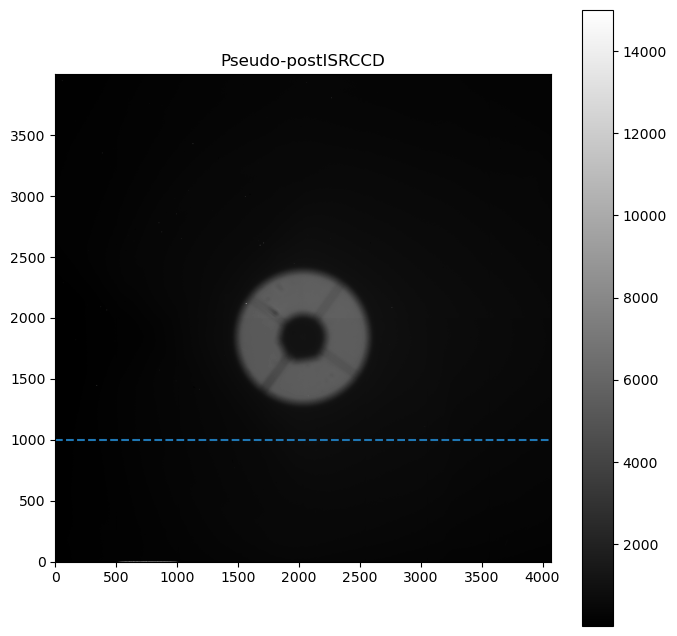

In [46]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
#im = ax.imshow(isr_test.exposure.image.array,cmap="gray",origin='lower',norm=LogNorm())
im = ax.imshow(test_,cmap="gray",origin='lower',vmin=10,vmax=15000)
ax.axhline(y=1000,ls='--')
ax.set_title('Pseudo-postISRCCD')
fig.colorbar(im,ax=ax)

In [34]:
#proj = np.sum(test_[1200:,:],axis=0)
proj_up = np.median(test_[2000:,:],axis=0)
proj_down = np.median(test_[1000:2000,:],axis=0)
proj = np.mean([proj_up,proj_down],axis=0)
print(test_.shape,proj_up.shape,proj_down.shape,proj.shape)
x_ = np.arange(proj.shape[0])

(4000, 4072) (4072,) (4072,) (4072,)


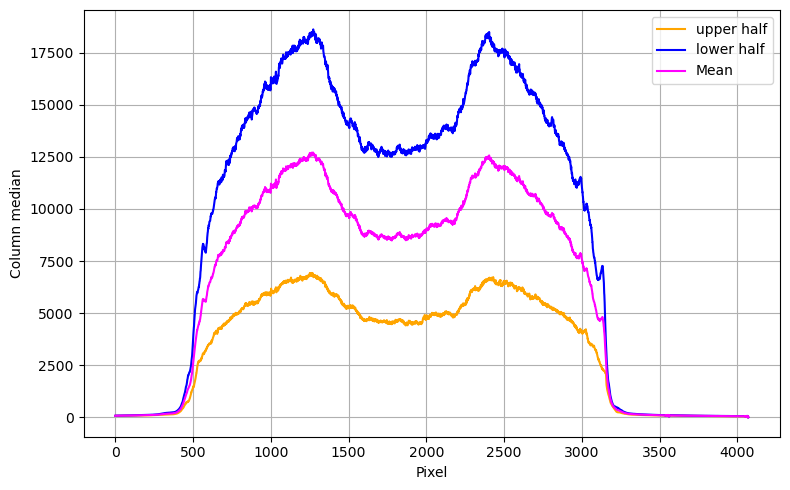

In [35]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.plot(x_,proj_up,color='orange',label='upper half')
ax.plot(x_,proj_down,color='b',label='lower half')
ax.plot(x_,proj,color='magenta',label='Mean')
ax.grid()
ax.set_xlabel('Pixel')
ax.set_ylabel('Column median')
ax.legend(loc="best")
plt.tight_layout()

In [36]:
#test_deproj = np.zeros(test_.shape)
#test_deproj[2000:,:] = test_[2000:,:]/proj_up[None,:]
#test_deproj[:2000,:] = test_[:2000,:]/proj_down[None,:]
test_deproj = test_/proj[None,:]
print(test_deproj.shape)

(4000, 4072)


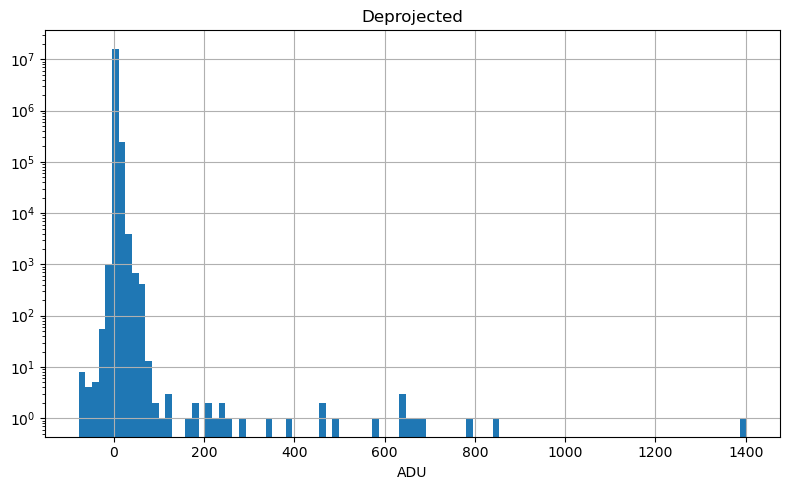

In [37]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
_ = ax.hist(test_deproj.flatten(),bins=100)
ax.set_yscale("log")
ax.grid()
ax.set_xlabel('ADU')
ax.set_title('Deprojected')
plt.tight_layout()

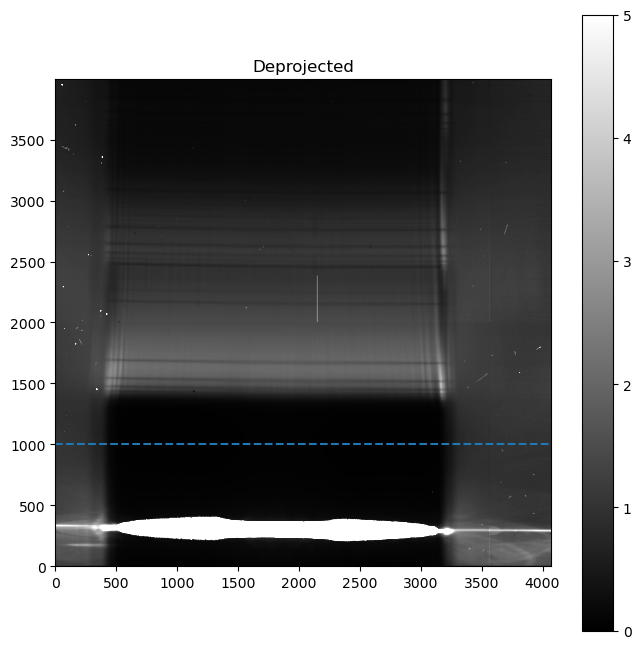

In [38]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
#im = ax.imshow(test_norm1,cmap="gray",origin='lower',norm=LogNorm())
im = ax.imshow(test_deproj,cmap="gray",origin='lower',vmin=0,vmax=5)
ax.axhline(y=1000,ls='--')
ax.set_title('Deprojected')
fig.colorbar(im,ax=ax)

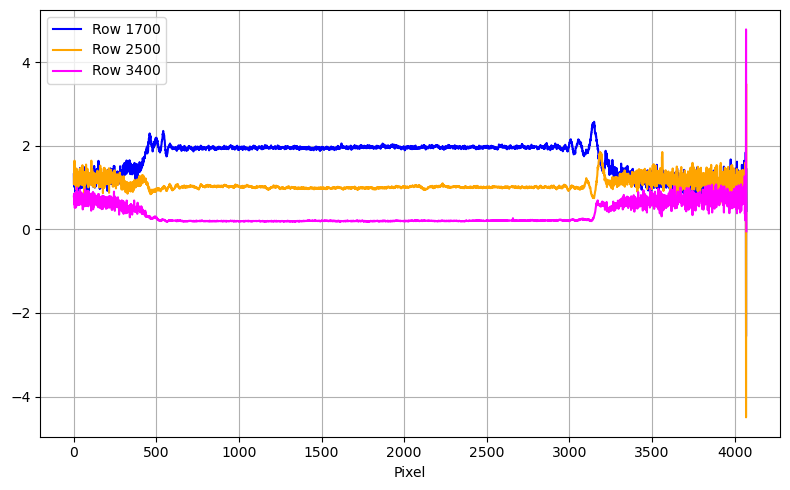

In [39]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.plot(x_,test_deproj[1700,:],color='b',label='Row 1700')
ax.plot(x_,test_deproj[2500,:],color='orange',label='Row 2500')
ax.plot(x_,test_deproj[3400,:],color='magenta',label='Row 3400')
ax.grid()
ax.set_xlabel('Pixel')
ax.legend(loc="best")
plt.tight_layout()

## Wavelength (row) normalization per amplifier 

In [40]:

print(test_deproj.shape)

test_lnorm = np.zeros(test_deproj.shape)
for key in ampli_boxes.keys():
    x0 = ampli_boxes[key][0]
    x1 = ampli_boxes[key][1]
    y0 = ampli_boxes[key][2]
    y1 = ampli_boxes[key][3]
    ampli_ = test_deproj[y0:y1,x0:x1]
    median_ = np.median(ampli_,axis=1)

    norm_ampli_ = ampli_/median_[:,None]
    print(norm_ampli_.shape)

    test_lnorm[y0:y1,x0:x1] = norm_ampli_
print(test_lnorm.shape)
print('-------------')


(4000, 4072)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(4000, 4072)
-------------


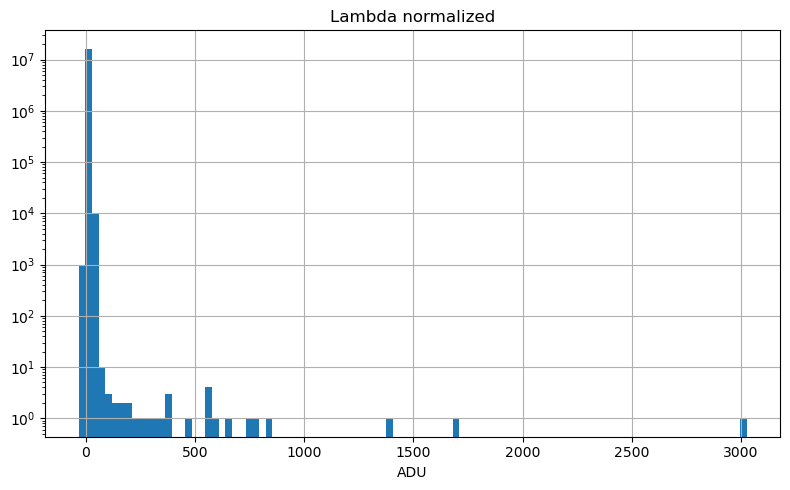

In [41]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
_ = ax.hist(test_lnorm.flatten(),bins=100)
ax.set_yscale("log")
ax.grid()
ax.set_xlabel('ADU')
ax.set_title('Lambda normalized')
plt.tight_layout()

In [42]:
# allow interactive plots
#%matplotlib widget
%matplotlib inline

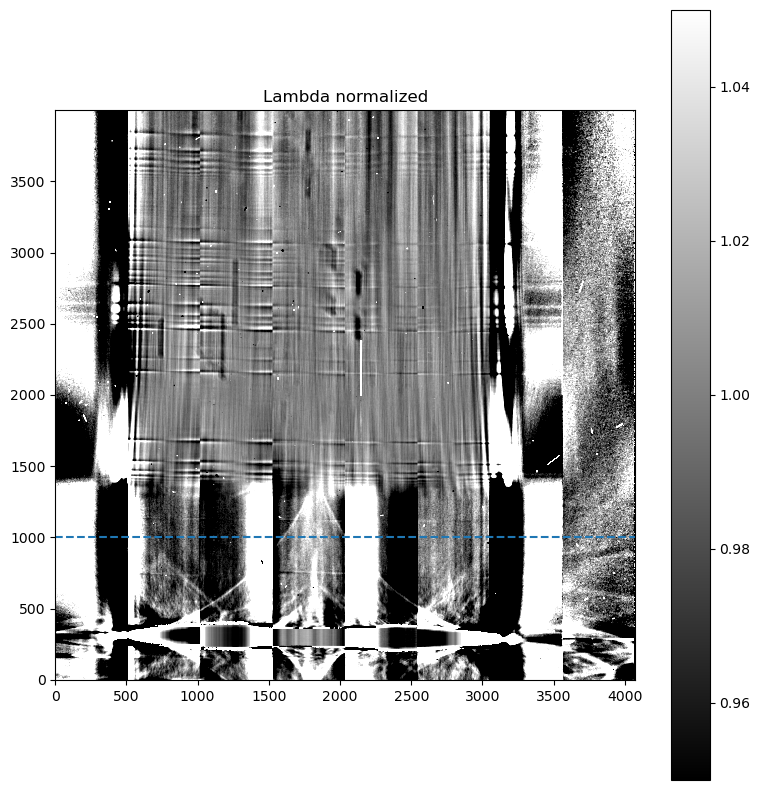

In [43]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
#im = ax.imshow(test_norm1,cmap="gray",origin='lower',norm=LogNorm())
im = ax.imshow(test_lnorm,cmap="gray",origin='lower',vmin=0.95,vmax=1.05)
ax.axhline(y=1000,ls='--')
ax.set_title('Lambda normalized')
fig.colorbar(im,ax=ax)
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
#im = ax.imshow(test_norm1,cmap="gray",origin='lower',norm=LogNorm())
im = ax.imshow(test_lnorm[2000:4000,750:2750],cmap="gray",origin='lower',vmin=0.95,vmax=1.05)
ax.axhline(y=1000,ls='--')
ax.set_title('Lambda normalized')
fig.colorbar(im,ax=ax)

# Create sum exposure from individual exposures 

## 1. Do pseudo-postISRCCD 

In [29]:
print(seq_nums)

[31 32 33 34 35 36 37 38]


In [30]:
exp_list = []
ampli_boxes = {}
ampli_names = []
for i,exp_id_ in enumerate(ids):
    print(exp_id_)
    raw_img_ = butler.get('raw', dataId={'exposure': exp_id_, 'instrument': 'LATISS', 'detector': 0}, collections = calibCollections)
    print('Raw image retrieved')
    
    bias_ = butler.get("bias",instrument=cameraName, exposure= exp_id_, detector=0, collections=calibCollections)
    defects_ = butler.get('defects',instrument=cameraName, exposure= exp_id_,detector=0,collections=calibCollections)
    
    #fast ISR 
    print('Running pseudo-ISR')
    isr_img_ = isr_task.run(raw_img_,bias=bias_,defects=defects_)
    
    exp_list.append(isr_img_)
    print('-----------------')
    
    if i==0:
        for ampIdx, amp in enumerate(raw_img_.getDetector()):
            ampli_name_ = amp.getName()
            ampli_names.append(ampli_name_)
            xbegin = amp.getBBox().x.begin
            xend = amp.getBBox().x.end
            ybegin = amp.getBBox().y.begin
            yend = amp.getBBox().y.end
            ampli_boxes[ampli_name_] = (xbegin,xend,ybegin,yend)
            
            md = raw_img_.getMetadata().toDict()
    

2023091400031
Raw image retrieved
Running pseudo-ISR


-----------------
2023091400032
Raw image retrieved
Running pseudo-ISR


-----------------
2023091400033
Raw image retrieved
Running pseudo-ISR


-----------------
2023091400034
Raw image retrieved
Running pseudo-ISR


-----------------
2023091400035
Raw image retrieved
Running pseudo-ISR


-----------------
2023091400036
Raw image retrieved
Running pseudo-ISR


-----------------
2023091400037
Raw image retrieved
Running pseudo-ISR


-----------------
2023091400038
Raw image retrieved
Running pseudo-ISR


-----------------


In [31]:
ampli_boxes

{'C10': (0, 509, 2000, 4000),
 'C11': (509, 1018, 2000, 4000),
 'C12': (1018, 1527, 2000, 4000),
 'C13': (1527, 2036, 2000, 4000),
 'C14': (2036, 2545, 2000, 4000),
 'C15': (2545, 3054, 2000, 4000),
 'C16': (3054, 3563, 2000, 4000),
 'C17': (3563, 4072, 2000, 4000),
 'C07': (3563, 4072, 0, 2000),
 'C06': (3054, 3563, 0, 2000),
 'C05': (2545, 3054, 0, 2000),
 'C04': (2036, 2545, 0, 2000),
 'C03': (1527, 2036, 0, 2000),
 'C02': (1018, 1527, 0, 2000),
 'C01': (509, 1018, 0, 2000),
 'C00': (0, 509, 0, 2000)}

In [32]:
mapampid = [0,1,2,3,4,5,6,7,15,14,13,12,11,10,9,8]

In [33]:
num_amplis = len(mapampid)

## 2. Wavelength (row) normalization 

We test the normalization with one exposure 

In [34]:
exp0 = exp_list[0].exposure.image.array

In [35]:
print(exp0.shape)

(4000, 4072)


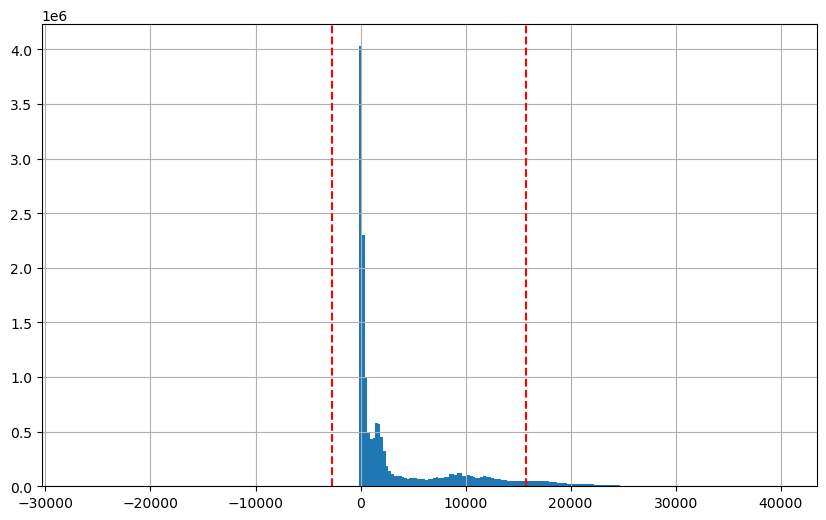

In [36]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
_ = ax.hist(exp0.flatten(),bins=1000)
mu = np.mean(exp0.flatten())
sigma = np.std(exp0.flatten())
nsigma = 0.5
ax.axvline(x=mu-nsigma*sigma,ls='--',color='r')
ax.axvline(x=mu+nsigma*sigma,ls='--',color='r')
ax.set_xlim(mu-2.*sigma,mu+2.*sigma)
ax.grid()

In [37]:
vmin = 1
vmax = 6000

(0.0, 4000.0)

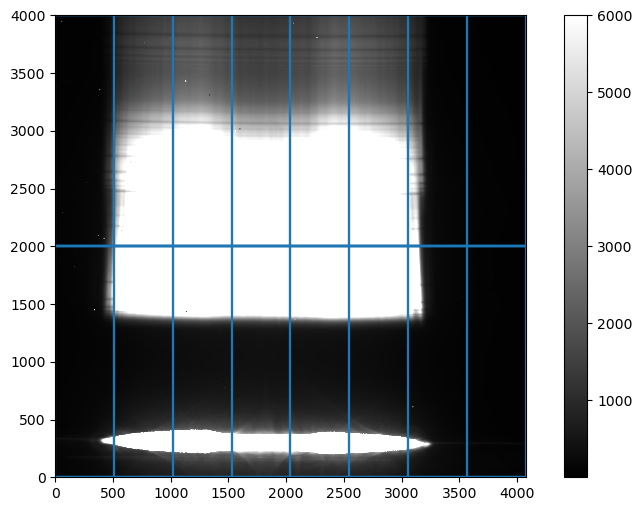

In [38]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
im = ax.imshow(exp0,cmap="gray",origin='lower',vmin=vmin,vmax=vmax)#,norm=LogNorm())
fig.colorbar(im,ax=ax)
for key in ampli_boxes.keys():
    ax.axvline(x=ampli_boxes[key][0])
    ax.axvline(x=ampli_boxes[key][1])
    ax.axhline(y=ampli_boxes[key][2])
    ax.axhline(y=ampli_boxes[key][3])
ax.set_xlim(0,4072)
ax.set_ylim(0,4000)

Visualize data per amplifier separately 

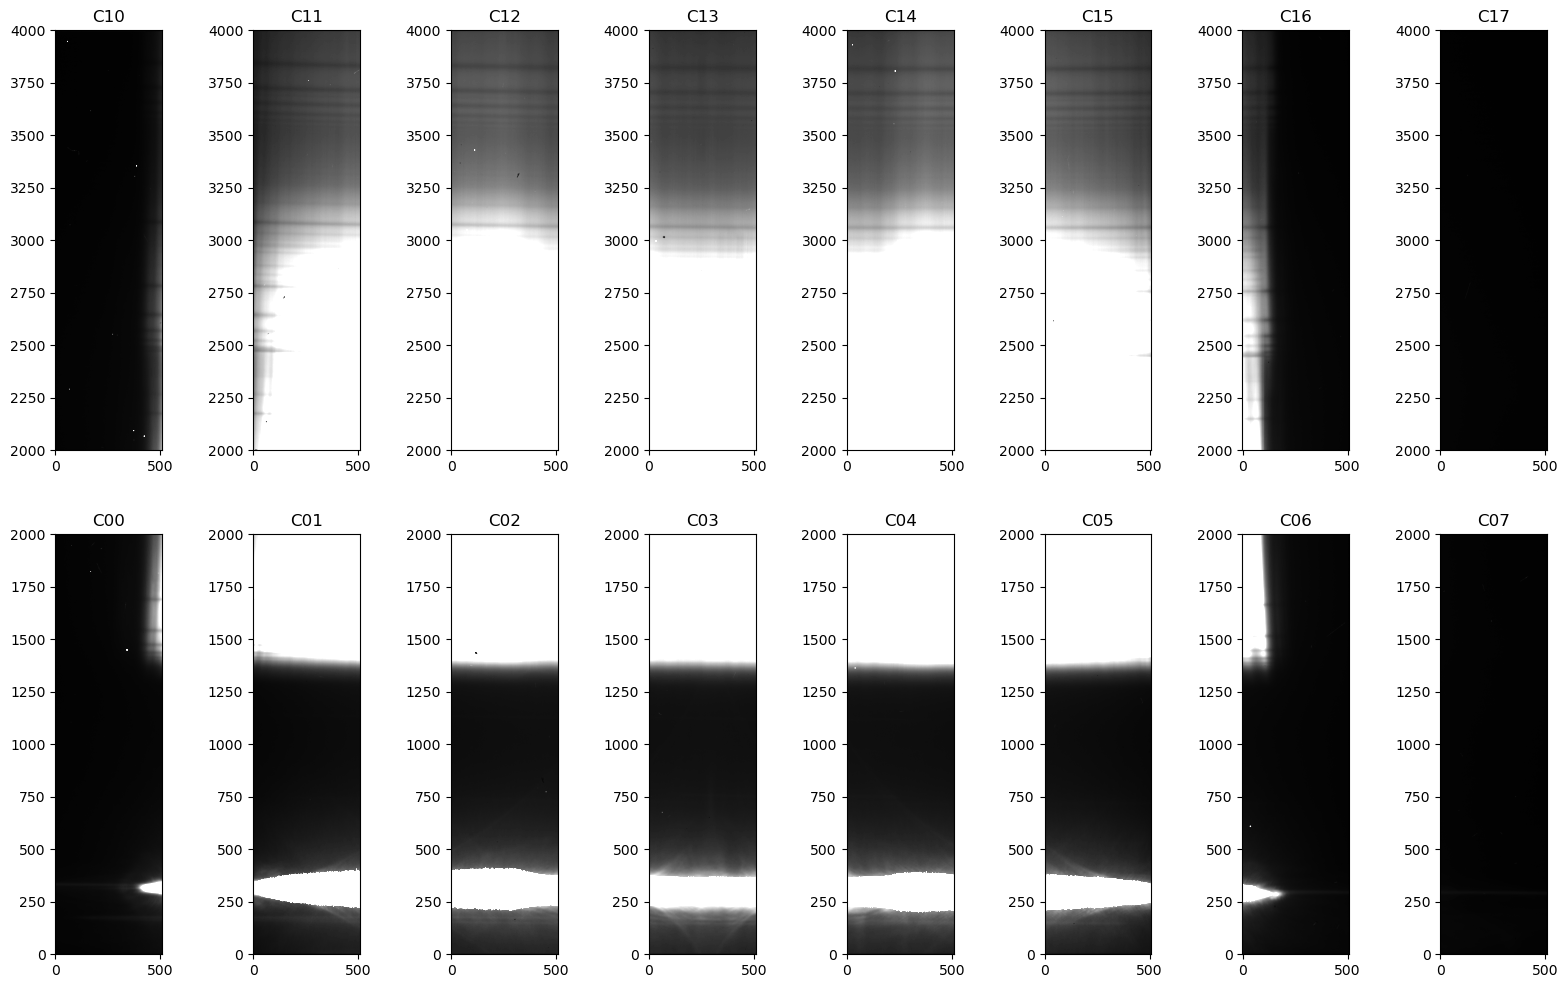

In [39]:
fig = plt.figure(figsize=(20,12))

for i,key in enumerate(ampli_boxes.keys()):
    x0 = ampli_boxes[key][0]
    x1 = ampli_boxes[key][1]
    y0 = ampli_boxes[key][2]
    y1 = ampli_boxes[key][3]
    ampli_ = exp0[y0:y1,x0:x1]
    
    ax = fig.add_subplot(2,8,mapampid[i]+1)
    im = ax.imshow(ampli_,cmap="gray",origin='lower',vmin=vmin,vmax=vmax)#,norm=LogNorm())
    yticks = ax.get_yticks()
    #print(yticks)
    ax.set_yticks(ticks=yticks[1:],labels=yticks[1:].astype('int')+y0)
    ax.set_title(key)

We normalize each row (per amplifier) to their median value. This way, we can compare exposure with different number counts (due to different effective exposure times) 

(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)


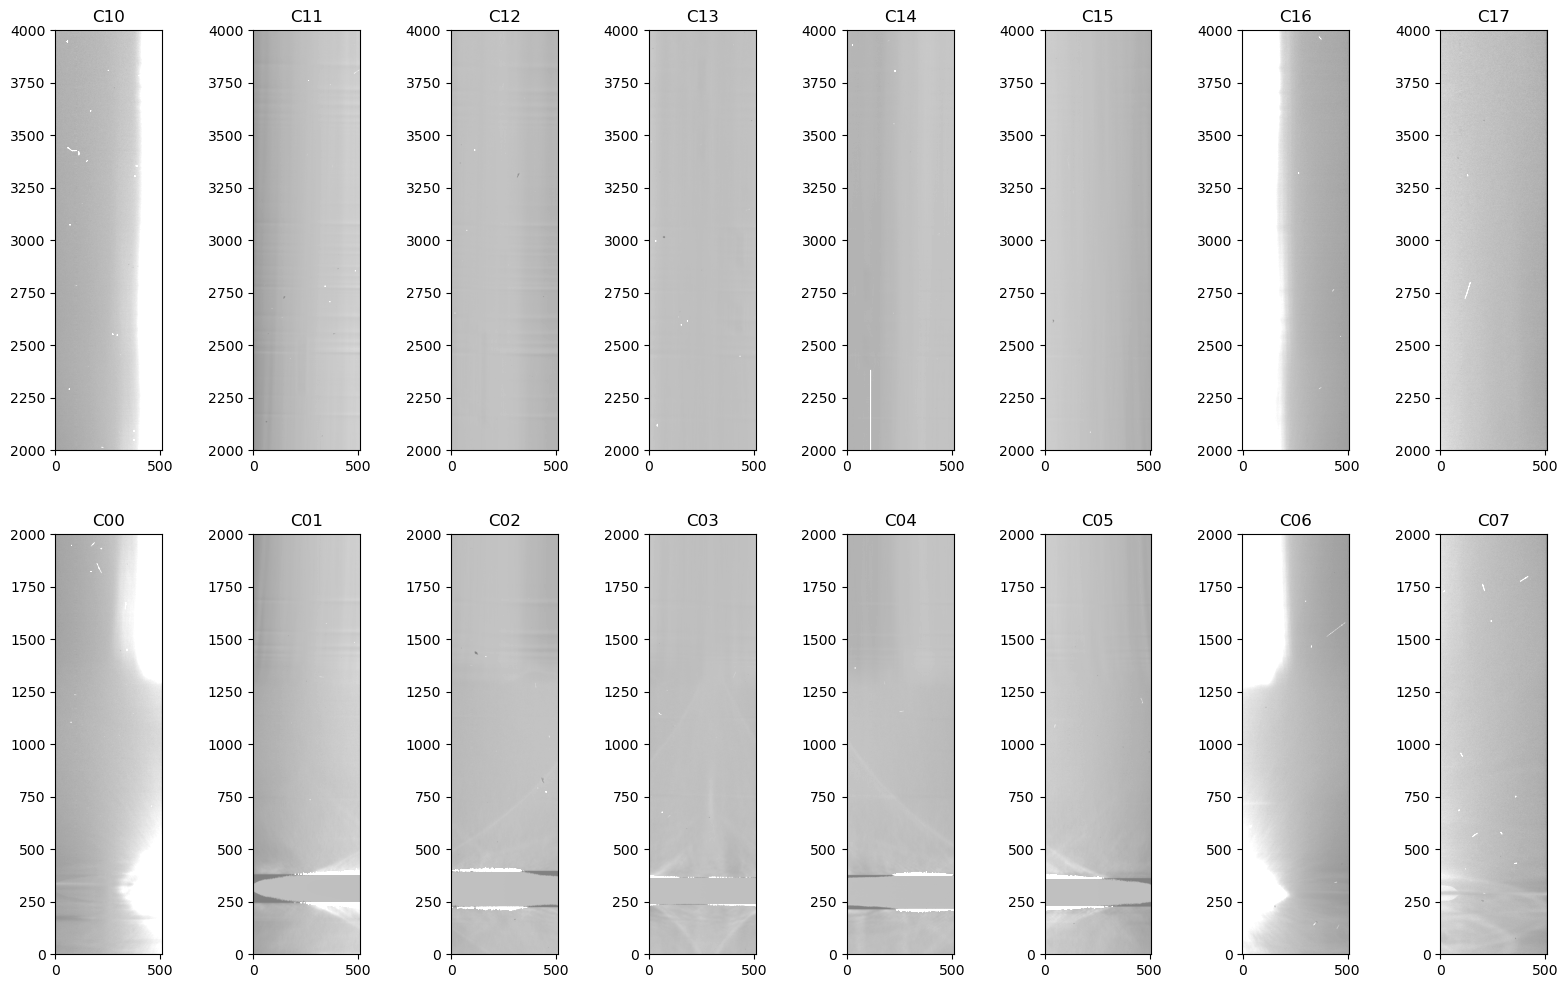

In [40]:
fig = plt.figure(figsize=(20,12))

for i,key in enumerate(ampli_boxes.keys()):
    x0 = ampli_boxes[key][0]
    x1 = ampli_boxes[key][1]
    y0 = ampli_boxes[key][2]
    y1 = ampli_boxes[key][3]
    ampli_ = exp0[y0:y1,x0:x1]
    median_ = np.median(ampli_,axis=1)
    
    norm_ampli_ = ampli_/median_[:,None]
    print(norm_ampli_.shape)
    
    ax = fig.add_subplot(2,8,mapampid[i]+1)
    im = ax.imshow(norm_ampli_,cmap="gray",origin='lower',vmin=-2,vmax=2)#,norm=LogNorm())
    yticks = ax.get_yticks()
    #print(yticks)
    ax.set_yticks(ticks=yticks[1:],labels=yticks[1:].astype('int')+y0)
    ax.set_title(key)


Now we do this systematically for all exposures and we combine taking their median pixel by pixel 

In [41]:
print(len(exp_list))

8


In [42]:
special_flat_ = []
for i,exp_ in enumerate(exp_list):
    print(i)
    data_ = exp_.exposure.image.array
    print(data_.shape)
    
    out_ = np.zeros(data_.shape)
    for key in ampli_boxes.keys():
        x0 = ampli_boxes[key][0]
        x1 = ampli_boxes[key][1]
        y0 = ampli_boxes[key][2]
        y1 = ampli_boxes[key][3]
        ampli_ = data_[y0:y1,x0:x1]
        median_ = np.median(ampli_,axis=1)

        norm_ampli_ = ampli_/median_[:,None]
        print(norm_ampli_.shape)
        
        out_[y0:y1,x0:x1] = norm_ampli_
    print(out_.shape)
    special_flat_.append(out_)
    print('-------------')
special_flat_ = np.array(special_flat_)
print(special_flat_.shape)

0
(4000, 4072)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(4000, 4072)
-------------
1
(4000, 4072)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(4000, 4072)
-------------
2
(4000, 4072)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(4000, 4072)
-------------
3
(4000, 4072)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(4000, 4072)
-------------
4
(4000, 4072)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(

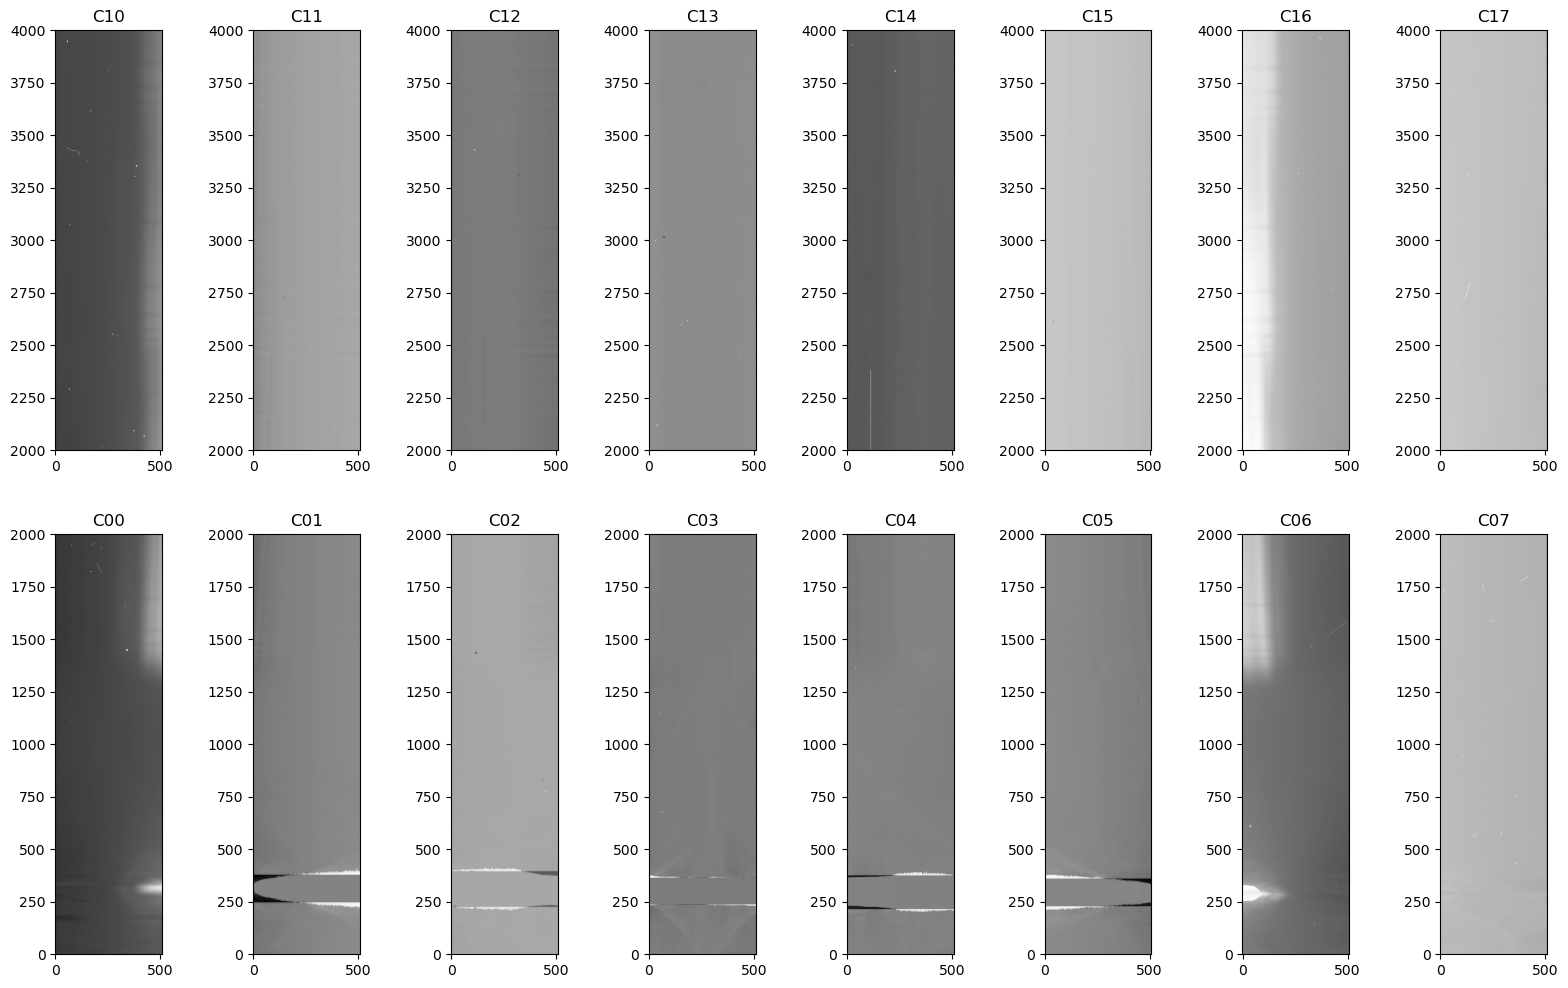

In [43]:
fig = plt.figure(figsize=(20,12))

for i,key in enumerate(ampli_boxes.keys()):
    x0 = ampli_boxes[key][0]
    x1 = ampli_boxes[key][1]
    y0 = ampli_boxes[key][2]
    y1 = ampli_boxes[key][3]
    ampli_ = special_flat_[0][y0:y1,x0:x1]
    
    ax = fig.add_subplot(2,8,mapampid[i]+1)
    im = ax.imshow(ampli_,cmap="gray",origin='lower',norm=LogNorm())
    yticks = ax.get_yticks()
    #print(yticks)
    ax.set_yticks(ticks=yticks[1:],labels=yticks[1:].astype('int')+y0)
    ax.set_title(key)

## 3. Compute median of individual exposures and combine into one 

In [44]:
special_flat = np.median(special_flat_,axis=0)

In [45]:
print(special_flat.shape)

(4000, 4072)


(0.0, 4000.0)

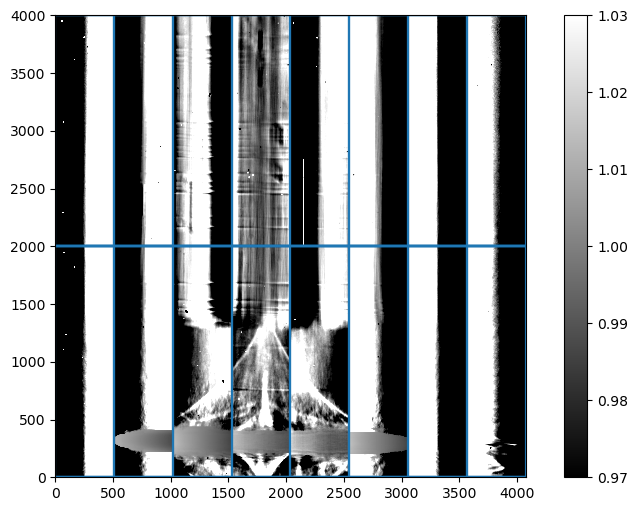

In [46]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
im = ax.imshow(special_flat,cmap="gray",origin='lower',vmin=0.97,vmax=1.03)#,norm=LogNorm())
fig.colorbar(im,ax=ax)
for key in ampli_boxes.keys():
    ax.axvline(x=ampli_boxes[key][0])
    ax.axvline(x=ampli_boxes[key][1])
    ax.axhline(y=ampli_boxes[key][2])
    ax.axhline(y=ampli_boxes[key][3])
ax.set_xlim(0,4072)
ax.set_ylim(0,4000)

# Save in fits file 

In [47]:
outdir_ = outdir_label.format(obs_day)
outdir = os.path.join(outdir_base,outdir_)
if os.path.exists(outdir)==False:
    os.mkdir(outdir)

In [48]:
filename_out = 'cyl_lens_flat_{0}.fits'.format(obs_day)
fullfilename_out = os.path.join(outdir,filename_out)

print(f">>>>  output filename {filename_out}")

hdr = fits.Header()
    
for key,value in md.items():
    hdr[str(key)] = value
    

# Be carefull for Spectractor, 2 hdu units are necessary

primary_hdu = fits.PrimaryHDU(header=hdr)
image_hdu = fits.ImageHDU(special_flat)

hdu_list = fits.HDUList([primary_hdu, image_hdu])

hdu_list.writeto(fullfilename_out,overwrite=True)

>>>>  output filename cyl_lens_flat_20230914.fits
